## Table of Contents

    1. Project Topic
    2. Data
    3. Data Cleaning
    4. EDA and Feature Engineering
    5. Hybrid Recommender System
        5.1 Content-based approach
        5.2 Collaborated approach
            5.2.1 SVD
            5.2.2 KNN
    6. Test
        6.1 Submission to Kaggle
        6.2 Results
    7. Conclusion

# 1. Project Topic

### 1.1 Purpose 

This is a report of Unsupervised Learning for the past kaggle competition **WSDM - KKBox's Music Recommendation Challenge**. The purpose of this project is to predict whether user listened to a song again within a month after the first observable listening. If yes, then y = 1, otherwise y = 0. Participants must predict y in probability, and the score is measured by `auc`.

https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/overview

### 1.2 Problems in data
This project has some problems for developping a recommender system.

**Rare items and new items**

90% of songs are appeared in train data less than 20 times, and those songs occupy 14% of train data. In addition, 7% of songs in test data did not appeared in train data. Those are new items which collaborative filtering does not work.

**Data size (memory issue)** 

To construct full user-item rating matrix, more than 100GB RAM is requrired. (419,781 songs x 34,403 users = 1.4e+10)


### 1.3 Methodology of Hybrid Recommender System

Considering problems of data, I decided to combine both content-based and collaborative approaches as Hybrid Recommender System. This system consists of following layers.

**recommender system layer**
1. Purely content-based approach according to features (artist, song length, etc): **Non-personalized**
2. To mix item bias into content-based approach (if an item has enuogh samples): **Non-personalized**
3. To mix user bias into content-based approach for frequent users (if a user has enough samples): **slightly personalized**
4. To mix collaborative method into content-based approach (for frequent users and items): **fully personalized**

Furthermore, I do not use any of supervised learning method, although **most of participants applied supervised learning approaches, specifically lightgbm and catboost** are apparently the most selected methods according to codes in kaggle competition. In the real situation, however, those methods are computationally expensive when millions of users access daily. In contrast, unsupervised approach has lower computation costs such as selecting vlaue from matrix, or inner product of arrays. Thereore, it is worth to know performence of unsupervised approach.



### 1.4 Target

The target of this project is **auc > 0.66** considering bench mark score and my RandomForest results. 

* KKBox Benchmark: auc 0.61337
* My RandomForestClassifier: auc 0.65998 (refer to another notebook `Appendix_RandomForest.ipynb`)

This project has generally low scores in kaggle leaderboard. auc 0.7 is top 50 of 1000 partcipants. 

# 2. Data

There are four data in this project. train and test data which consists of user-item and its rating (train only). In addition, feature of item ans users are also provided. 

**Data Source**

https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from surprise import Dataset, Reader, SVD, KNNWithMeans, KNNBaseline
from sklearn import metrics
import time

**train data**

Train data consists of `userID`, `itemID` and `rating`. In addition, `source_system_tab` (where a user played song) is indicated. `source_system_tab` is the most important feature (refer to chapter 4.). 

In [2]:
train_df = pd.read_parquet("data_p1/train_p1.parquet")

In [116]:
n_train = train_df.shape[0]
print("train data size", train_df.shape)

train data size (7377418, 12)


In [4]:
train_df.head()

,source_system_tab,source_screen_name,source_type,rating,userID,itemID
0,explore,Explore,online-playlist,1,21893,335731
1,my library,Local playlist more,local-playlist,1,26052,357849
2,my library,Local playlist more,local-playlist,1,26052,210391
3,my library,Local playlist more,local-playlist,1,26052,308876
4,explore,Explore,online-playlist,1,21893,222980


**test data**

The format of test data is similar to trian data.

In [5]:
test_df = pd.read_parquet("data_p1/test_p1.parquet")

In [117]:
n_test = test_df.shape[0]
print("test data size", test_df.shape)

test data size (2556790, 12)


In [7]:
test_df.head()

,id,source_system_tab,source_screen_name,source_type,userID,itemID
0,0,my library,Local playlist more,local-library,29464,187683
1,1,my library,Local playlist more,local-library,29464,2101
2,2,discover,None,song-based-playlist,24266,10113
3,3,radio,Radio,radio,22501,78829
4,4,radio,Radio,radio,22501,42570


**user data**

User data consists of city, bd (age), gender, registered_via, registration and expiration time. In this project, only `userID` is used, because collaborative method does not require them. Rating information are most important feature for collaborative method.

In [8]:
member_df = pd.read_parquet("data_p1/members_p1.parquet")

In [118]:
n_member = member_df.shape[0]
print("user data size", member_df.shape)

user data size (34403, 7)


In [10]:
member_df.head()

,city,bd,gender,registered_via,registration_init_time,expiration_date,userID
0,1,0,None,7,20110820,20170920,0
1,1,0,None,7,20150628,20170622,1
2,1,0,None,4,20160411,20170712,2
3,1,0,None,9,20150906,20150907,3
4,1,0,None,4,20170126,20170613,4


**item data**

Item data consists of artist, genre, compose, lyricist, language and song_length. In this project, `song_length`, `artist_id`, `itemID` are used. composer, genre, language are not used becacuse they are duplicated with `artist`.  

In [3]:
song_df = pd.read_parquet("data_p1/songs_p1.parquet")

In [4]:
n_song = song_df.shape[0]
print("item data size", song_df.shape)

item data size (419781, 8)


In [5]:
song_df.head()

,song_length,genre_ids,artist_name,composer,lyricist,language,artist_id,itemID
0,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0,41671,0
1,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,3365,1
2,231781,465,SUPER JUNIOR,None,None,31.0,29563,2
3,273554,465,S.H.E,湯小康,徐世珍,3.0,29342,3
4,140329,726,貴族精選,Traditional,Traditional,52.0,44699,4


# 3. Data Cleaning

Data cleaning is implemented in another notebook `Data_Cleaning.ipynb`. It has the following procedures:

* item ID and user ID were replaced with integers, because original IDs were very long string data.
* There are a lot of songs which do not appear in train and test data. They are removed from the original song list.
* To fill NaN values with "None" in `source_system_tab` column of train and test data.  

**Count of NaN**

In [14]:
train_df.isna().sum()

source_system_tab     0
source_screen_name    0
source_type           0
rating                0
userID                0
itemID                0
dtype: int64

In [15]:
test_df.isna().sum()

id                    0
source_system_tab     0
source_screen_name    0
source_type           0
userID                0
itemID                0
dtype: int64

# 4. EDA and Feature Engineering

### 4.1 Distribution

**rating**

In the train data, numbers of 0 and 1 are solmost similar. It is balanced.

Text(0.5, 1.0, 'Distribution of rating(Y) in train data')

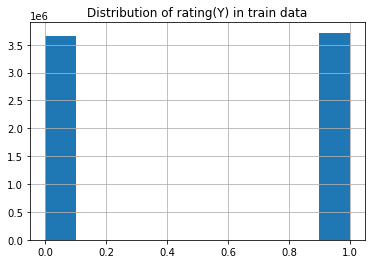

In [16]:
fig, ax = plt.subplots()
train_df["rating"].hist(ax = ax)
ax.set_title("Distribution of rating(Y) in train data")

**users**

Number of samples of users ranges from 1 to more than 1000. The mode is 1, and distribution decreases as the number of samples increases. 
It shows that there are lots of users that cannot rely on collaborative approach only. 

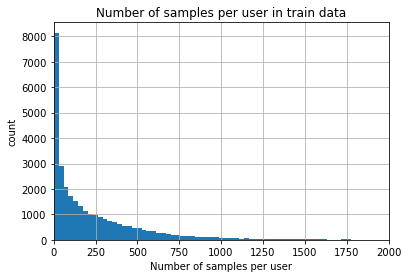

In [17]:
fig, ax = plt.subplots()
train_df[["userID", "rating"]].groupby("userID").count().hist(bins = 200, ax = ax)
ax.set_xlim(0, 2000)
ax.set_ylabel("count")
ax.set_xlabel("Number of samples per user")
ax.set_title("Number of samples per user in train data")
plt.show()

**items**

There are so many songs which has only one sample in train data. It makes histogram (left) harder to see, Histogram in Log scale (right one) shows that there are songs which have more than 10,000 samples. 

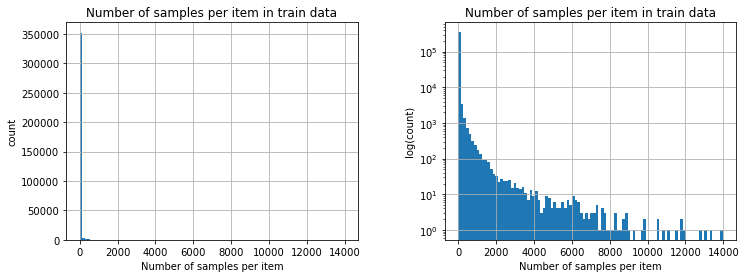

In [18]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
train_df[["itemID", "rating"]].groupby("itemID").count().hist(bins = 100, ax = ax[1])
train_df[["itemID", "rating"]].groupby("itemID").count().hist(bins = 100, ax = ax[0])
ax[1].set_yscale("log")
ax[1].set_ylabel("log(count)")
ax[0].set_ylabel("count")
for i in range(2):
    ax[i].set_xlabel("Number of samples per item")
    ax[i].set_title("Number of samples per item in train data")
plt.show()

### 4.2 Grouping "source_system_tab" to "source_id"

`source_system_tab` is the most important basic feature, because there are significant difference of mean rating between sources. For example, `my library` has highest mean rating. Of course it is highest, because a song is added to library by a user. In contrast, `radio` is lowest in mean rating. It is also plausible because radio plays songs randomly, and user tends to forget its name. Furthermore, `discover`, `explore`, `search` would mean the same thing where user actively search songs. 

Text(0.5, 1.0, 'Histogram')

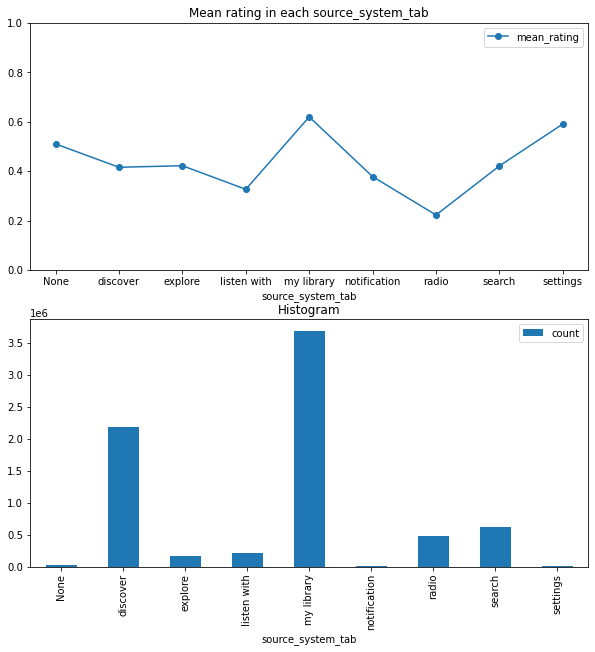

In [120]:
fig, ax = plt.subplots(2, figsize = (10, 10))
train_df[["source_system_tab", "rating"]].groupby("source_system_tab").mean().rename({"rating":"mean_rating"}, axis = 1).plot(ax=ax[0], marker = "o")
#ax.axhline(y = train_df["rating"].mean(), ls = "-.", color = "red", label = "global mean")
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title("Mean rating in each source_system_tab")

train_df[["source_system_tab", "rating"]].groupby("source_system_tab").count().rename({"rating":"count"}, axis = 1).plot.bar(ax=ax[1])
ax[1].set_title("Histogram")

**Gouping source and convert to integer**

Based on mean rating and interpretation, similar values are grouped, and converted into integer.

In [20]:
g0_set = set(["my library", "settings"])
g1_set = set(["discover", "explore", "search"])
g2_set = set(["listen with", "notification"])
g3_set = set(["radio"])

def source_id(source):
    
    if source in g0_set:
        return 0
    
    if source in g1_set:
        return 1
    
    if source in g2_set:
        return 2
    
    if source in g3_set:
        return 3
    
    return 4
    

In [21]:
train_df["source_id"] = train_df["source_system_tab"].apply(lambda x: source_id(x))
test_df["source_id"] = test_df["source_system_tab"].apply(lambda x: source_id(x))

### 4.3 Time Series Feature: Time since the first play

Raing of music must be sentitive in time. People get tired of popular songs after a while. Thus, mean rating should be decayed in time.
Although there is no information about time in data, I assumed that index is allocated in time order. I created new feature `time_firstplay` which means the time when the song firstly played in the data. Then for all the songs in the data, `time_since_firstplay` is calculated. It is divided by $5.0 * 10^5$, because value is too large. 

In [22]:
train_df["time"] = np.arange(n_train)
test_df["time"] = np.arange(n_train, n_train + n_test)

In [23]:
time_first_df = pd.concat([train_df[["itemID", "time"]], test_df[["itemID", "time"]]]).groupby("itemID").min().reset_index().rename({"time":"time_firstplay"}, axis = 1)

In [24]:
train_df = train_df.merge(time_first_df, on = "itemID", how = "left")
test_df = test_df.merge(time_first_df, on = "itemID", how = "left")
train_df["time_since_firstplay"] = (train_df["time"] - train_df["time_firstplay"])//(10**5*5)
test_df["time_since_firstplay"] = (test_df["time"] - test_df["time_firstplay"])//(10**5*5)

### 4.4 Song minutes

`song_length` apparently shows the length of song in milliseconds scale. It is more convenient to convert it into minutes.


In [25]:
song_df["song_minute"] = np.round(song_df["song_length"]/(10**3*60))

In [26]:
song_df[["song_length", "song_minute"]].head()

,song_length,song_minute
0,247640,4.0
1,197328,3.0
2,231781,4.0
3,273554,5.0
4,140329,2.0


### 4.5 Artists' mean rating

To add feature attributed to artist and song minute, `artist_id` and `song_minute` is merged to train and test data from the song list.

In [27]:
train_df = train_df.merge(song_df[["itemID", "artist_id", "song_minute"]], on = "itemID", how = "left")
test_df = test_df.merge(song_df[["itemID", "artist_id", "song_minute"]], on = "itemID", how = "left")

In [28]:
# fill NaN with -1
filter1 = train_df["artist_id"].isna()
train_df.loc[filter1, "artist_id"] = -1
train_df["artist_id"] = train_df["artist_id"].astype(int)

filter1 = test_df["artist_id"].isna()
test_df.loc[filter1, "artist_id"] = -1
test_df["artist_id"] = test_df["artist_id"].astype(int)

### 4.6 Visualizing features

`feature_prob` function calculate mean rating of each value in labels (specified columns). It exclude validations data, and data with small number of counts (< min_count) are removed. It returns dictionary for prediction and dataframe for visualization.

In [29]:
def feature_prob(labels, n_val, min_count):
        
    n_train = train_df.shape[0]
    
    # to exclude validation data from feature
    n_train2 = n_train - n_val
    
    select =  labels + ["rating"]
    sum_df=train_df[select].iloc[:n_train2,:].groupby(labels).sum()
    count_df=train_df[select].iloc[:n_train2,:].groupby(labels).count()
    
    # small count is removed from 
    p_df = (sum_df/count_df)
    filter1 = count_df["rating"] > min_count
        
    p_df = p_df.loc[filter1,:].reset_index()

    key_array = p_df[labels].to_numpy()
    val_array = p_df["rating"].to_numpy()
    
    p_dic = {}
    for i in range(key_array.shape[0]):
        #print(key_array[i])
        p_dic[tuple(key_array[i])] = val_array[i]
    
    return p_dic,p_df

#### Validation Size

Validation data is the latter 20% of train data. It means that the validation data is newer than train data.  Sklearn's train_test_split is NOT used because train and validation shall not be shuffled.

In [30]:
n_val = int(n_train*0.2)
n_val

1475483

**Features**

Mean rating by `source_id` is called **global mean** in this report. Mean rating of `artist_id`, `song_minute`, `time_since_firstplay`, `itemID`, `userID` are calculated by each `source_id`. They are used for content-based approach.

In [31]:
p_source_dic, p_source_df = feature_prob(["source_id"], n_val, 0)
p_artist_dic, p_artist_df = feature_prob(["artist_id", "source_id"], n_val, 20)
p_songmin_dic, p_songmin_df = feature_prob(["song_minute", "source_id"], n_val, 20)
p_songage_dic, p_songage_df = feature_prob(["time_since_firstplay", "source_id"], n_val, 20)
p_song_dic, p_song_df = feature_prob(["itemID", "source_id"], n_val, 20)
p_user_dic, p_user_df = feature_prob(["userID", "source_id"], n_val, 20)

### Global mean

Mean rating by each source is called **global mean** in this project, because all the prediction methods will be divided by source.

Text(0.5, 1.0, 'Global mean')

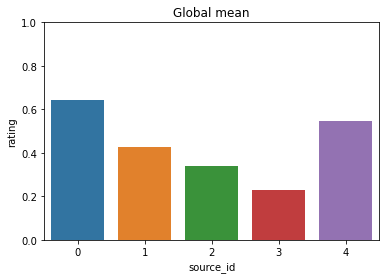

In [32]:
fig, ax = plt.subplots()
sns.barplot( data = p_source_df, x = "source_id", y = "rating", ax = ax)
ax.set_ylim(0,1)
ax.set_title("Global mean")

### Artists' mean rating

Artists' mean rating is distributed normally around global means. Standard deviation is not so small according to plots which indicates importance of artists as a feature for a recommender system. 

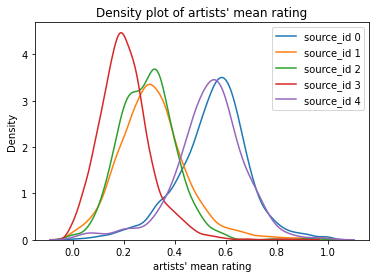

In [127]:
fig, ax = plt.subplots()
for i in range(5):
    filter1 = p_artist_df["source_id"] == i
    sns.kdeplot(data = p_artist_df.loc[filter1], x = "rating", label = "source_id " + str(i), ax = ax)

ax.legend()
ax.set_xlabel("artists' mean rating")
ax.set_title("Density plot of artists' mean rating")
plt.show()

### Song minutes' mean rating

There are some trends in mean rating. For example, too short song (< 2 min) has lower values. Apparently 3-5 min songs are most popular in all sources.  

Text(0.5, 1.0, 'song minute and mean rating')

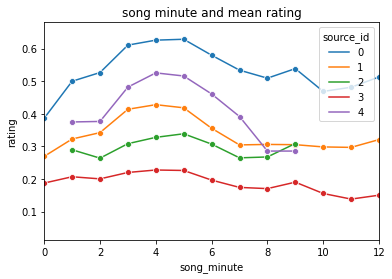

In [125]:
fig, ax = plt.subplots()
sns.lineplot(data = p_songmin_df, x = "song_minute", y = "rating", hue = "source_id", palette = "tab10", marker = "o")
ax.set_xlim(0, 12)
ax.set_title("song minute and mean rating")

### Mean rating in time since the first play

As expected, mean rating decays as the time passes since the first play in the data. Interestingly, mean rating takes peak at 1 (not at 0). Parhaps it takes a while until songs become popular.

Text(0.5, 1.0, 'Mean rating of time since the first play')

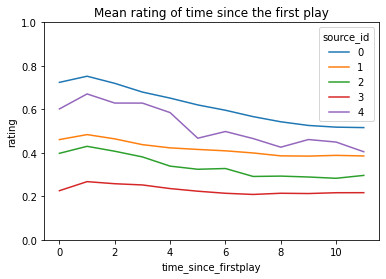

In [35]:
fig, ax = plt.subplots()
sns.lineplot(data = p_songage_df, x = "time_since_firstplay", y = "rating", hue = "source_id", palette = "tab10", ax = ax)
ax.set_ylim(0,1)
ax.set_title("Mean rating of time since the first play")

# 5. Hybrid Recommender System

## 5.1 Content-based approach

The function `content_based` predict rating according to features of songs. First it fills all values with global mean. Second, when featre is available, rating is predicted by mean of **artists' bias**, **song minutes' bias**, and **time since the first play bias** (called 'song age' in code).

When number of samples per item is more than 20, item bias (mean rating) is considered. So does user bias. The function `content_itembias_mixed` predicts rating according to item bias. `mix_rate` is a parameter to be tuned. The function `userbias_mixed` does same for user bias. 

In [100]:
def content_based(source_array, artist_array, songage_array, songmin_array, max_songage):
    
    n = source_array.shape[0]
    
    yhat_array = np.zeros(n)
    
    #global mean
    for i in range(n):
        yhat_array[i] = p_source_dic[(source_array[i],)]
    
    for i in range(n):
        source = source_array[i]
        artist = artist_array[i]
        songage = songage_array[i]
        songmin = songmin_array[i]

        age = min(max_songage, songage)

        hasvalue = False
        
        # to select value from feature dictionary. When no value, it is nan.

        try:
            val1 = p_artist_dic[(artist, source)]
            hasvalue = True
        except KeyError:
            val1 = np.nan

        try:
            val2 = p_songmin_dic[(songmin, source)]
            hasvalue = True
        except KeyError:
            val2 = np.nan

        try:
            val3 = p_songage_dic[(songage, source)]
            hasvalue = True
        except KeyError:
            val3 = np.nan

        #When at least one feature provided value, mean value is calculated 
        if hasvalue:
            yhat_array[i] = np.nanmean([val1, val2, val3])
    
    return yhat_array

In [54]:
def content_itembias_mixed(yhat_array, song_array, source_array, mix_rate):
    
    #yhat_array: already predicted value of rating. It is updated as 'yhat_array2' by this function
    
    #to copy array first. To avoid bug.
    yhat_array2 = yhat_array.copy()
    n = yhat_array.shape[0]
    
    count = 0
    for i in range(n):
        try:
            count += 1
            #select value from song bias dictionary. weighted by `mix_rate`
            yhat_array2[i] = (p_song_dic[(song_array[i], source_array[i])])*mix_rate + (1-mix_rate)*yhat_array2[i]
        except KeyError:
            pass 
        
    ratio = count/n*100
    
    print(np.round(ratio), "% of data is predicted by item bias")
        
    return yhat_array2

def userbias_mixed(yhat_array, member_array, source_array, mix_rate):

    #yhat_array: already predicted value of rating. It is updated as 'yhat_array2' by this function
    
    n = yhat_array.shape[0]
    
    #to copy array first. To avoid bug.
    yhat_array2 = yhat_array.copy()
    
    count = 0
    for i in range(n):
        try:
            count += 1
            yhat_array2[i] = (p_user_dic[(member_array[i], source_array[i])])*mix_rate + (1-mix_rate)*yhat_array2[i]
        except KeyError:
            pass
        
        
    ratio = count/n*100
    
    print(np.round(ratio), "% of data is predicted by user bias")
    
    return yhat_array2

In [38]:
song_val = train_df["itemID"].iloc[-n_val:].to_numpy()
member_val =  train_df["userID"].iloc[-n_val:].to_numpy()
y_val = train_df["rating"].iloc[-n_val:].to_numpy()
source_val =  train_df["source_id"].iloc[-n_val:].to_numpy()
artist_val = train_df["artist_id"].iloc[-n_val:].to_numpy()
songmin_val = train_df["song_minute"].iloc[-n_val:].to_numpy()
songage_val = train_df["time_since_firstplay"].iloc[-n_val:].to_numpy()

### Content based (feature only)

The result is auc 0.6046. It is better than random guess, but still not as good as KKBox bench mark (0.6133). 

In [39]:
yhat_val = content_based(source_val, artist_val, songage_val, songmin_val, max_songage = 11)

In [40]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
auc_content = metrics.auc(fpr, tpr)
print("auc", auc_content)

auc 0.6045991233289622


### Item bias mixed

Item bias contributed auc (0.6217). The best hyper parameter is  `mix_rate = 1`.

In [41]:
yhat_val2 = yhat_val.copy()
mix_rates = [0.3, 0.5, 0.7, 1.0]
score = []
for mix_rate in mix_rates:
    yhat_val2 = content_itembias_mixed(yhat_val, song_val, source_val, mix_rate)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val2, pos_label=1)
    score.append(metrics.auc(fpr, tpr))


Text(0.5, 1.0, 'AUC of content-based with item bias')

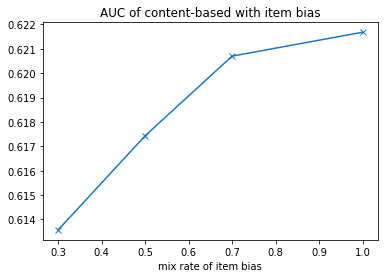

In [42]:
fig, ax = plt.subplots()
ax.plot(mix_rates, score, marker  = "x")
ax.set_xlabel("mix rate of item bias")
ax.set_title("AUC of content-based with item bias")

In [43]:
yhat_val2 = content_itembias_mixed(yhat_val, song_val, source_val, mix_rate = 1)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val2, pos_label=1)
auc_content_item = metrics.auc(fpr, tpr)
print("auc", auc_content_item)

auc 0.621679702535197


### user bias mixed

User bias improved auc significantly (0.6568). The best mix_rate = 0.5. 

In [44]:
mix_rates = [0.3, 0.5, 0.7, 1.0]
score = []
for mix_rate in mix_rates:
    yhat_val3 = userbias_mixed(yhat_val2, member_val, source_val, mix_rate)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val3, pos_label=1)
    score.append(metrics.auc(fpr, tpr))


Text(0.5, 1.0, 'AUC when user bias is mixed')

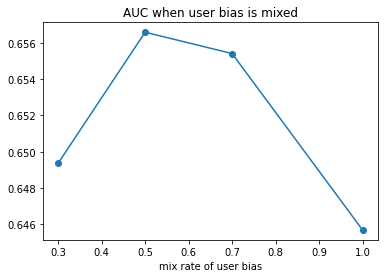

In [85]:
fig, ax = plt.subplots()
plt.plot(mix_rates, score, marker = "o")
ax.set_xlabel("mix rate of user bias")
ax.set_title("AUC when user bias is mixed")

In [46]:
yhat_val3 = userbias_mixed(yhat_val2, member_val, source_val, mix_rate = 0.5)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val3, pos_label=1)
auc_content_user = metrics.auc(fpr, tpr)
print("auc", auc_content_user)

auc 0.6565790255664664


## 5.2 Collaborative method (tuning and model selection)

`collaborative_data` select items and users which have more than minimum required samples, and create data for collaborative method. `collaborative_mixed` predict rating by trained model with mix_rate.

In [47]:
def collaborative_data(n_val, min_user, min_item):
    
    n_train = train_df.shape[0]
    
    # to exclude validation data 
    n_train2 = n_train - n_val
    
    train_df2 = train_df.iloc[:n_train2,:]
    
    # query to remove minor item and users
    query1 =  "rating >" + str(min_user)
    query2 =  "rating >" + str(min_item)
    
    # create user and item list
    user_list = train_df2[["userID", "rating"]].groupby("userID").count().query(query1).reset_index()["userID"].to_numpy()
    item_list = train_df2[["itemID", "rating"]].query("itemID >= 0").groupby("itemID").count().query(query2).reset_index()["itemID"].to_numpy()
    
    user_set = set(user_list)
    item_set = set(item_list)

    #filter out minor items and users
    filter1 = (train_df2["userID"].apply(lambda x: x in user_set)) & (train_df2["itemID"].apply(lambda x: x in item_set)) 

    train_df3 = train_df2[["userID", "itemID", "source_id", "rating"]].loc[filter1]
    
    print(len(user_set),"users, ",  len(item_set), "items")
    
    return train_df3
    

In [81]:
def collaborative_mixed(model_collab, yhat_array,  member_array, song_array, source_array, item_set, user_set, mix_rate):
    n = yhat_array.shape[0]
    yhat_array2 = yhat_array.copy()
    count = 0
    time1 = time.time()
    
    for i in range(n):
        user = member_array[i]
        item = song_array[i]
        source = source_array[i]

        if (item in item_set) and (user in user_set):
            count += 1
            yhat_array2[i] = model_collab[source].predict(user, item, verbose=False).est*mix_rate + (1-mix_rate)*yhat_array2[i]

    ratio = count/n*100
    
    print(np.round(ratio), "% of data is predicted by collaborative approach")
    
    time2 = time.time()
    time3 = np.round(time2 - time1)
    print("calculation time ", time3, "sec")
    
    return yhat_array2
    

### SVD: hyperparameter tuning 

To develop train data for collaborative method, rare items and users should be removed to avoid **cold start problem**. This selection also reduces memory usage.

In [49]:
svd_df = collaborative_data(n_val, min_user = 20, min_item = 20)
user_set_svd = set(svd_df["userID"].to_numpy())
item_set_svd = set(svd_df["itemID"].to_numpy())

22264 users,  29640 items


To convert data for `surprise` package, its Reader object is required. Train data is divided into each `source_id` (refer to chapter 4) to develop model by each source. 

In [50]:
reader = Reader(rating_scale=(0, 1))

In [51]:
data_svd = []
for source in range(5):
    filter1 = svd_df["source_id"] == source
    data_svd.append(Dataset.load_from_df(svd_df[["userID", "itemID", "rating"]].loc[filter1,:], reader).build_full_trainset())

**train and hyperparameter tuning**

`SVD_train` function trains SVD model with specified `n_factor` (number of latent features). Hyperparameter of this model is `n_factor` of SVD and `mix_rate`. 

In [52]:
def SVD_train(n_factor, data_list):
    
    time1 = time.time()
    
    model_sp = []
    #algo = SVD(n_factors = n_factor, n_epochs = 40)
    for i in range(5):
        print("train model for source", i)

        model_sp.append(SVD(n_factors = n_factor, n_epochs = 40, random_state = 0).fit(data_list[i]))
        
    time2 = time.time()
    
    print("train time ", np.round(time2 - time1), "sec")
    
    return model_sp

In [53]:
n_factors = [15, 25, 40, 60]
mix_rates = [0.3, 0.5, 0.7, 1.0]

scores_list_svd = []
model_svd_list = []

for n_factor in n_factors:
    print("svd n_factor", n_factor)
    scores = []
    model_svd = SVD_train(n_factor, data_svd)
    model_svd_list.append(model_svd)
    
    for mix_rate in mix_rates:
        
        yhat_val4 = collaborative_mixed(model_svd, yhat_val3,  member_val, song_val, source_val,item_set_svd, user_set_svd, mix_rate)
        fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val4, pos_label=1)
        auc = metrics.auc(fpr, tpr)
        print("mix_rate",mix_rate, "auc", auc)
        scores.append(auc)
        
    scores_list_svd.append(scores)


svd n_factor 15
train model for source 0
train model for source 1
train model for source 2
train model for source 3
train model for source 4
train time  110.0 sec
mix_rate 0.3 auc 0.6639652773849642
mix_rate 0.5 auc 0.6657576279887057
mix_rate 0.7 auc 0.6658035763821014
mix_rate 1.0 auc 0.6639238667278499
svd n_factor 25
train model for source 0
train model for source 1
train model for source 2
train model for source 3
train model for source 4
train time  127.0 sec
mix_rate 0.3 auc 0.664157109302922
mix_rate 0.5 auc 0.6659476577115482
mix_rate 0.7 auc 0.6659227877450445
mix_rate 1.0 auc 0.6638608872735827
svd n_factor 40
train model for source 0
train model for source 1
train model for source 2
train model for source 3
train model for source 4
train time  143.0 sec
mix_rate 0.3 auc 0.6641147056197373
mix_rate 0.5 auc 0.6657711453845717
mix_rate 0.7 auc 0.6655750635659111
mix_rate 1.0 auc 0.6632575883105313
svd n_factor 60
train model for source 0
train model for source 1
train model fo

Text(0.5, 1.0, 'Hybrid Recommender System score')

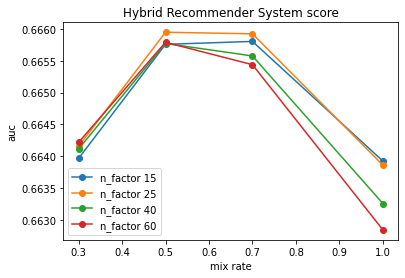

In [86]:
fig, ax = plt.subplots()

for i in range(4):
    ax.plot(mix_rates, scores_list_svd[i], label = "n_factor " + str(n_factors[i]), marker = "o")
    
ax.legend()
ax.set_ylabel("auc")
ax.set_xlabel("mix rate")
ax.set_title("Hybrid Recommender System score")

**The best hyperparameter**

The best hypter-parameter is n_factor = 25 and mix_rate = 0.5.
It improved auc to 0.6659. It means that SVD works well. Furthermore, time for training and prediction are both short (**low computation cost**). 

In [82]:
mix_rate = 0.5
yhat_val4 = collaborative_mixed(model_svd_list[1], yhat_val3,  member_val, song_val, source_val, item_set_svd, user_set_svd, mix_rate)

69.0 % of data is predicted by collaborative approach
calculation time  16.0 sec


In [83]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val4, pos_label=1)
auc_svd = metrics.auc(fpr, tpr)
print("auc", auc_svd)

auc 0.6659476577115482


### KNN

Another typical approac is KNN collaborative method. It first calculate similarity matrix, then rating is predicted by weighted mean of top K nearest neighbours. To compute similarity matrix, RAM size is critical, thus the number of user and item should be smaller than SVD method. Furthermore, calculation time is longer for both train and prediction.

In [62]:
knn_df = collaborative_data(n_val, min_user = 200, min_item = 50)
user_set_knn = set(knn_df["userID"].to_numpy())
item_set_knn = set(knn_df["itemID"].to_numpy())

10197 users,  14567 items


In [63]:
data_knn = []
for source in range(5):
    filter1 = knn_df["source_id"] == source
    data_knn.append(Dataset.load_from_df(knn_df[["userID", "itemID", "rating"]].loc[filter1,:], reader).build_full_trainset())

KNN of surprise package can choose `user_based` or `item_based` for calculating similarity and bias. Unfortunately it, cannot use user_bias + item-item similarity. It can use **user_bias + user-user sim** or **item_bias + item-item sim**. Since the user bias increased auc a lot in content-based, `user_biased` parameter should be `True`.

In [66]:
def KNNWithMeans_train(data_list):
    sim_options = {
    "name": "pearson_baseline",
    "user_based": True, 
    }
    
    time1 = time.time()
    
    model_sp = []
    for i in range(5):
        print("train model for source", i)

        model_sp.append(KNNWithMeans(k = 30,sim_options=sim_options).fit(data_list[i]))
    
    time2 = time.time()
    
    print("train time ", np.round(time2 - time1), "sec")
    
    return model_sp

In [67]:
model_KNNWithMeans = KNNWithMeans_train(data_knn)

train model for source 0
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train model for source 1
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train model for source 2
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train model for source 3
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train model for source 4
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
train time  770.0 sec


In [84]:
mix_rate = 1
yhat_val5 = collaborative_mixed(model_KNNWithMeans, yhat_val3,  member_val, song_val, source_val, item_set_knn, user_set_knn, mix_rate)
fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val5, pos_label=1)
auc_knn = metrics.auc(fpr, tpr)
print("auc", auc_knn)

44.0 % of data is predicted by collaborative approach
calculation time  481.0 sec
auc 0.6569478381391844


As a result, KNN slightly improved auc, but not as good as SVD. Memory usage of similarity for KNN is much larger than SVD, so I decreased number of item and users. Furthermore, both **training and prediction took more than 10 times longer than SVD**. Therefore, I select SVD as collaborative method. 

## 5.3 Validation Results

In this hybrid recommender sytem, four methods are mixed by tuned **mix_rate** and **hyperparameters**. As layer goes deeper, auc is improved as shown in the figure.

In [87]:
methods = ["feature only content-based (CB)", "CB + item bias", "CB + item bias + user bias", "Hybrid: CB + item bias + user bias + SVD"]
auc_models = [auc_content, auc_content_item, auc_content_user, auc_svd]
result_df = pd.DataFrame({"method": methods, "auc": auc_models})

Text(0.5, 1.0, 'Validation result')

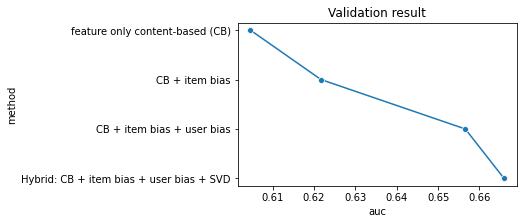

In [110]:
fig, ax = plt.subplots(figsize = (5, 3))
sns.lineplot(data = result_df, y = "method", x = "auc", marker = "o")
ax.set_title("Validation result")

# 6. Test
## 6.1 Submission to Kaggle

Rating for test data is predicted in the same way. First, mean rating of feature is calculated. `n_val` (validation size) is zero. 

In [91]:
n_val = 0
p_source_dic, p_source_df = feature_prob(["source_id"], n_val, 0)
p_artist_dic, p_artist_df = feature_prob(["artist_id", "source_id"], n_val, 20)
p_songmin_dic, p_songmin_df = feature_prob(["song_minute", "source_id"], n_val, 20)
p_songage_dic, p_songage_df = feature_prob(["time_since_firstplay", "source_id"], n_val, 20)
p_song_dic, p_song_df = feature_prob(["itemID", "source_id"], n_val, 20)
p_user_dic, p_user_df = feature_prob(["userID", "source_id"], n_val, 20)

Select item and users above threshold (20), and create data for `surprise` package.

In [92]:
svd_df = collaborative_data(n_val, min_user = 20, min_item = 20)
user_set_svd = set(svd_df["userID"].to_numpy())
item_set_svd = set(svd_df["itemID"].to_numpy())

24134 users,  35487 items


In [93]:
data_svd = []
for source in range(5):
    filter1 = svd_df["source_id"] == source
    data_svd.append(Dataset.load_from_df(svd_df[["userID", "itemID", "rating"]].loc[filter1,:], reader).build_full_trainset())

training for test data takes only few minutes.

In [94]:
model_svd = SVD_train(25, data_svd)

train model for source 0
train model for source 1
train model for source 2
train model for source 3
train model for source 4
train time  163.0 sec


In [97]:
song_test = test_df["itemID"].to_numpy()
member_test =  test_df["userID"].to_numpy()
source_test =  test_df["source_id"].to_numpy()
artist_test = test_df["artist_id"].to_numpy()
songage_test = test_df["time_since_firstplay"].to_numpy()
songmin_test = test_df["song_minute"].to_numpy()

In [101]:
yhat_test = content_based(source_test, artist_test, songage_test, songmin_test, max_songage = p_songage_df["time_since_firstplay"].max())

In [102]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/contentbased.csv", index = False)

In [103]:
yhat_test2 = content_itembias_mixed(yhat_test, song_test, source_test, mix_rate = 1)

100.0 % of data is predicted by item bias


In [104]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test2
sample_df.to_csv("output/contentbased_songmixed.csv", index = False)

**user bias**

In [105]:
yhat_test3 = userbias_mixed(yhat_test2,  member_test, source_test, mix_rate=0.5)

100.0 % of data is predicted by user bias


In [106]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test3
sample_df.to_csv("output/contentbased_userbiasmixed.csv", index = False)

**svd**

In [107]:
yhat_test4 =  collaborative_mixed(model_svd, yhat_test3,  member_test, song_test, source_test, item_set_svd, user_set_svd, mix_rate = 0.5)

66.0 % of data is predicted by collaborative approach
calculation time  26.0 sec


In [108]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test4
sample_df.to_csv("output/collaborative_contentmixed.csv", index = False)

## 6.2 Score

As a result, kaggle private score is increased as adding methods just like validation result. AUC is even slightly better than validation, it means that the validation plan was appropriate for this project. 

In [109]:
methods = ["feature only content-based (CB)", "CB + item bias", "CB + item bias + user bias", "Hybrid: CB + item bias + user bias + SVD"]
auc_models = [0.62048, 0.62696, 0.66284, 0.6675]
kaggle_df = pd.DataFrame({"method": methods, "auc": auc_models})

Text(0.5, 1.0, 'Scores')

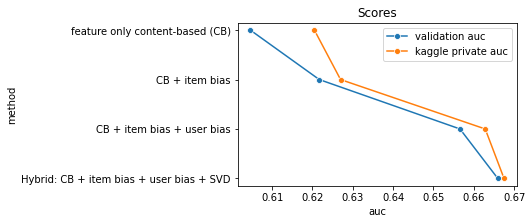

In [115]:
fig, ax = plt.subplots(figsize = (5, 3))
sns.lineplot(data = result_df, y = "method", x = "auc", marker = "o", label = "validation auc")
sns.lineplot(data = kaggle_df, y = "method", x = "auc", marker = "o", label = "kaggle private auc")
ax.set_title("Scores")

# 7. Conclusion

This hybrid system which consists of **feature only content-based**, **item bias**, **user bias**, and **SVD** worked successfully and achieved my target (**auc > 0.66**).

In this project, the main problem was data size and memory usage which attribute to large number of unique items and users. Howeber, I noticed that it is unncessesary to create rating matrix of whole users and items, because SVD does not work well for rate items (**cold start problem**). Thus, I decided to combine SVD with content-based approach which fairly works for new items when some features are available.

Another finding is efficiency of SVD in `surprise` packages. Generally, svds in popular packages such as `numpy` and `sklearn` requires imputation of NaN values, and this operation blurs features. However, according to the paper[1] which reffered by `surprise`, this SVD mask our unrated item-user pairs by  $R_{i,j}$ for calculating loss. I guess that `surprise` calculte latent features without creating rating matrix. Parhaps that's why the memory usage is much smaller than conventional svds, and better in performance.

### Reference:

[1] Ruslan Salakhutdinov and Andriy Mnih. Probabilistic matrix factorization. 2008. 
URL: https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf.

[2] Surpsie: Matrix Factorization-based algorithms 
https://surprise.readthedocs.io/en/stable/matrix_factorization.html